In [1]:
import datacube
from datacube.utils import masking 
from odc.ui import with_ui_cbk
import matplotlib.pyplot as plt
import xarray as xr
from scipy import ndimage

import sys
sys.path.insert(1, '../Tools/')
from datacube.utils.cog import write_cog
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.datahandling import pan_sharpen_brovey
from dea_tools.landcover import plot_land_cover

# Masking landcover with Geodatacoast

## load some data to test

In [2]:
dc = datacube.Datacube(app="03_Products_and_measurements")

In [3]:
#name area

area_name= 'canberra'

year = '2020'

#select a center point for an AOI 
# point_x, point_y = (-35.2226, 149.1185)
point_x, point_y =(-40.0296, 148.1154)

point_x, point_y =( -38.9452, 146.2559)

#Select sise of area (check on map below that you are happy with extent before proceeding)
lat = (point_x-0.3, point_x+0.3)
lon = (point_y-0.3, point_y+0.3)

#display area on map
display_map(x=lon, y=lat)

In [4]:

query = {
    "x": lon,
    "y": lat,
#     "time": (f"{year}-01-01", f"{year}-12-31"),
    "output_crs": "EPSG:3577",
    'resolution': (-25, 25),
    "group_by": "solar_day",
    }


geodatacoast = dc.load(product="geodata_coast_100k",
         **query)

landcover = dc.load(product="ga_ls_landcover_class_cyear_2", measurements='level4', time ='2020',
         **query)

## Define the mask.
in the geodata layer: 
    0 = ocean
    1 = island
    2 = mainland


In [5]:
#mask landcover with geocoast. we make the ocean be 1 and everything else be 0

MASK = xr.ones_like(landcover.level4).where(geodatacoast.land.isel(time=0) < 1, 0)

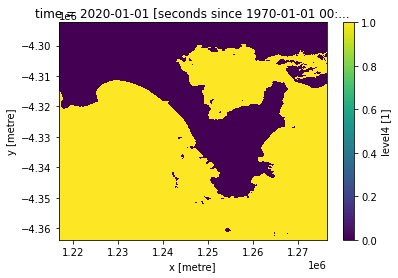

In [6]:
#lets' look at the basic mask

MASK.plot()

## now it's time to buffer out the ocean
this library has lots of different fuctions for dialtion and erossion : https://docs.scipy.org/doc/scipy/reference/ndimage.html. for starters we will try scipy.ndimage.binary_erosion(), and arbitarily errode by one Km (40 * 25m pixles)

In [15]:

output_array = xr.DataArray(ndimage.binary_erosion(MASK.isel(time=0), iterations=40))

#remove time dimmesion by selecting first time index. make it an xarray for easy plotting

In [16]:
output_array

<xarray.DataArray (dim_0: 2855, dim_1: 2384)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Dimensions without coordinates: dim_0, dim_1

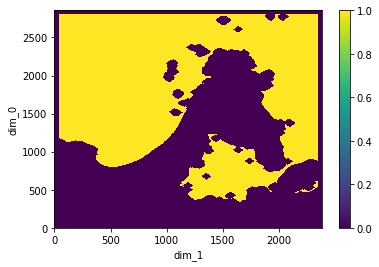

In [17]:
output_array.plot()

#It's upside down I don't know why. and Why is is buddering around the edge and how do we top that!! we wi;

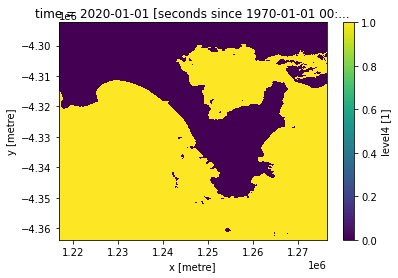

Notes: 

looks like we would be better off making the land be 1, the ocean be 0 and using dialation rather than erode. 